# Example 1: Add on site SOC term to wannier90_hr of TaAs system.

In [2]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
from tbsoc.lib.lm_expand import MapLmSp, MapLpSm, MapLzSz
from tbsoc.lib.const import Mtrans
from tbsoc.lib.printmat import printsocmat
from tbsoc.lib.read_in import read_poscar_wan_in, read_hr,read_EIGENVAL,read_KPOINTS
from tbsoc.lib.soc_mat import creat_basis_lm,get_matrix_lmbasis,trans_lm_spatial,soc_order,get_mat_soc_orb,get_Hsoc
from tbsoc.lib.cal_tools import hr2hk
from tbsoc.lib.plot_tools import band_plot
from tbsoc.lib.write_hr import write_hr
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### 1.  Initialization. read wannier90.win and POSCAR


In [5]:
workdir='./'
Lattice, atoms, atom_proj, orbitals, orb_num, orb_type = \
        read_poscar_wan_in(poscarfile = workdir + 'POSCAR',waninfile = workdir+'wannier90.win')

## build the soc matrix.
Msoc={}
for orb in np.unique(orbitals):
    Msoc_orb = get_mat_soc_orb(orb)
    Msoc[orb] = Msoc_orb

num_interaction = len(np.unique(orb_type))
print(u'number of lambda of soc is %d' %num_interaction)

reading POSCAR ...
successfully reading POSCAR ...
reading wannier90.win ...
successfully reading wannier90.win ...
The projections is :
Ta 	d 	
Ta 	d 	
Ta 	d 	
Ta 	d 	
As 	p 	
As 	p 	
As 	p 	
As 	p 	
generating Hsoc mat for dorbital in atomic orbital basis
   0.00    0.00    0.00   -1.73    0.00    1.73I   0.00    0.00    0.00    0.00 

   0.00    0.00    1.73    0.00    1.73I   0.00    0.00    0.00    0.00    0.00 

   0.00    1.73    0.00    0.00   -1.00I   0.00    0.00   -1.00    0.00    1.00I

  -1.73    0.00    0.00    0.00    0.00    1.00I   1.00    0.00    1.00I   0.00 

   0.00   -1.73I   1.00I   0.00    0.00    0.00    0.00   -1.00I   0.00   -1.00 

  -1.73I   0.00    0.00   -1.00I   0.00    0.00   -1.00I   0.00    1.00    0.00 

   0.00    0.00    0.00    1.00    0.00    1.00I   0.00    0.00   -2.00I   0.00 

   0.00    0.00   -1.00    0.00    1.00I   0.00    0.00    0.00    0.00    2.00I

   0.00    0.00    0.00   -1.00I   0.00    1.00    2.00I   0.00    0.00    0.00 

   0

### 2.  Read non soc hopping files, and return the Hamiltonian in the form,
$
\left[
 \begin{matrix}
   H & 0\\
   0 & H \\
  \end{matrix} 
\right]
$

In [6]:
hop_spinor, Rlatt, indR0 = read_hr(workdir+'wannier90_hr.dat')
nrpts = hop_spinor.shape[0]
num_wan = 2 * np.sum(orb_num)
if num_wan!=hop_spinor.shape[1]:
    print ("number of wannier orbitals is wrong!")
    exit()

reading wannier90_hr.dat ...
successfully reading wannier90_hr.dat ...


### 3. Set SOC interaction strength.
**
the length of lambdas equals to orbital type. 
**

In [7]:
print ('The orbital type is: ', orb_type)
print ('The length of lambdas should be %d' %len(np.unique(orb_type)))

The orbital type is:  [0, 0, 0, 0, 1, 1, 1, 1]
The length of lambdas should be 2


### 4.  Add $H_{soc}$ to the non_soc Hamiltonian


In [11]:
lambdas=[0.2,0.1]
Hsoc = get_Hsoc(lambdas,orbitals,orb_type,orb_num,Msoc)
hop_soc = hop_spinor * 1.0
hop_soc[indR0] += Hsoc

### 5. Read the self-consistent SOC  band structure from DFT package.
**
In this part, we want to calculate the band structure along the same k-paths to make a comparison with the  
the DFT band. The DFT band structure could be calculated from any first-principles packages, but here I just use the VASP as an axample.
**

In [12]:
kpath, xpath, xsymm, plot_sbol = read_KPOINTS(Lattice, kpofile = workdir+'KPOINTS')
vasp_bands, vasp_kps = read_EIGENVAL(FILENAME=workdir+'EIGENVAL')

reading KPOINTS ...
Z : [   0.000,   0.000,   0.500] ===>  G : [   0.000,   0.000,   0.000]
G : [   0.000,   0.000,   0.000] ===>  X : [  -0.500,   0.000,   0.000]
X : [  -0.500,   0.000,   0.000] ===>  M : [  -0.500,   0.500,   0.000]
M : [  -0.500,   0.500,   0.000] ===>  Y : [   0.000,   0.500,   0.000]
Y : [   0.000,   0.500,   0.000] ===>  G : [   0.000,   0.000,   0.000]
G : [   0.000,   0.000,   0.000] ===>  S : [  -0.500,   0.500,   0.500]
S : [  -0.500,   0.500,   0.500] ===>  P : [   0.000,   0.500,   0.500]
P : [   0.000,   0.500,   0.500] ===>  Z : [   0.000,   0.000,   0.500]
Z : [   0.000,   0.000,   0.500] ===>  U : [  -0.500,   0.000,   0.500]
U : [  -0.500,   0.000,   0.500] ===>  S : [  -0.500,   0.500,   0.500]
successfully reading KPOINTS ...
reading EIGENVAL ...
successfully reading EIGENVAL ...


### 6. Calculate band structure using the Hamiltonian with on-site SOC

In [13]:
Hksoc=hr2hk(hop_soc,Rlatt,kpath,num_wan)
bandsoc = np.linalg.eigvalsh(Hksoc)

### 7. Plot band structure

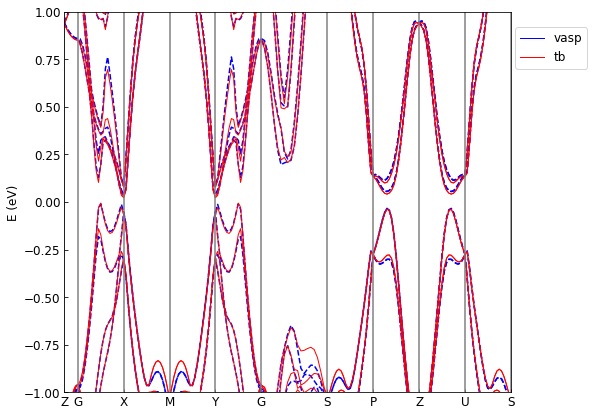

0

In [14]:
EMIN=-1
EMAX= 1
Efermi=7.0293
#band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandnsoc, pl_tb=True, pl_vasp=False, bndvasp=0)
band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandsoc, pl_tb=True,
          pl_vasp=True, bndvasp=vasp_bands,savedir=workdir)


### 8 . Define a objective function to be optimized.

**
Here we must know that which band in vasp_bands corresponding to which band in tb_bands.
Thus this part is much ad hoc. When using this part, please be careful.
**

**
Note: Before optimization, we should give a good initial guess of the lambdas. Otherwise, the 
optimization may be time consuming.
**


In [15]:
def creat_hsoc(lambdas):
    Hsoc = get_Hsoc(lambdas,orbitals,orb_type,orb_num,Msoc)    
    hop_soc = hop_spinor * 1.0
    hop_soc[indR0] += Hsoc
    Hksoc=hr2hk(hop_soc,Rlatt,kpath,num_wan)
    bandsoc = np.linalg.eigvalsh(Hksoc)
    picktb = bandsoc[:,0+20:40] * 1.0
    picktb = picktb - np.average(picktb)
    pickvasp = vasp_bands[:,8+20:8+40] * 1.0
    pickvasp = pickvasp - np.average(pickvasp)
    return np.sqrt(np.average((picktb - pickvasp)**2))

In [17]:
# initial guess.
lambdas0 = [0.2,0.15]
err = creat_hsoc(lambdas0)
print('initial err is: %10.5f' %err)

res = minimize(creat_hsoc, lambdas0, method='nelder-mead',\
    options={'maxiter':50,'fatol':1e-2,'fatol': 1e-3, 'disp': True})

initial err is:    0.02760
Optimization terminated successfully.
         Current function value: 0.027513
         Iterations: 22
         Function evaluations: 43


In [18]:
res

 final_simplex: (array([[0.19274907, 0.15329966],
       [0.19274121, 0.15322617],
       [0.1927614 , 0.15326935]]), array([0.0275127, 0.0275127, 0.0275127]))
           fun: 0.02751270220307469
       message: 'Optimization terminated successfully.'
          nfev: 43
           nit: 22
        status: 0
       success: True
             x: array([0.19274907, 0.15329966])

### 9. write the soc hr file

In [1]:
# write_hr(workdir,hop_soc,Rlatt)